In [1]:
import random
import pandas as pd


city_prices = {
    'Mataram': 60,
    'Senggigi': 40,
    'Mandalika': 35
}


def make_houses(n_houses, city_prices):
    cities = [city for city in city_prices for _ in range(n_houses)]
    sizes = [round(random.gauss(200, 50)) for _ in range(len(cities))]
    prices = [
        round(random.uniform(0.8, 1.2) * city_prices[city] * size)
        for city, size in zip(cities, sizes)
    ]
    return pd.DataFrame({
        'city': cities,
        'size': sizes,
        'price': prices
    })

In [2]:
houses = make_houses(100, city_prices)
#houses.sample(5)

In [3]:
houses

,city,size,price
0,Mataram,185,13318
1,Mataram,208,10455
2,Mataram,302,20994
3,Mataram,249,13859
4,Mataram,207,11466
...,...,...,...
295,Mandalika,147,4558
296,Mandalika,211,8551
297,Mandalika,129,4079
298,Mandalika,158,5700


In [7]:
houses[(houses['city']=="Mataram")].describe()

,size,price
count,100.000000,100.00000
mean,200.720000,11965.94000
std,48.218375,3147.25613
min,93.000000,5336.00000
25%,168.500000,9633.00000
50%,194.000000,11802.50000
75%,227.000000,13899.25000
max,322.000000,20994.00000


In [8]:
houses[(houses['city']=="Senggigi")].describe()

,size,price
count,100.000000,100.00000
mean,209.350000,8333.80000
std,52.174798,2423.10116
min,51.000000,2282.00000
25%,173.500000,6897.75000
50%,212.000000,8162.00000
75%,242.250000,10054.50000
max,360.000000,16733.00000


In [9]:
houses[(houses['city']=="Mandalika")].describe()

,size,price
count,100.000000,100.000000
mean,195.140000,6925.380000
std,50.835051,1936.516339
min,92.000000,2721.000000
25%,156.500000,5666.000000
50%,197.000000,7012.500000
75%,229.250000,8144.500000
max,342.000000,11239.000000


Text(0.5, 1.0, '100 simulated houses')

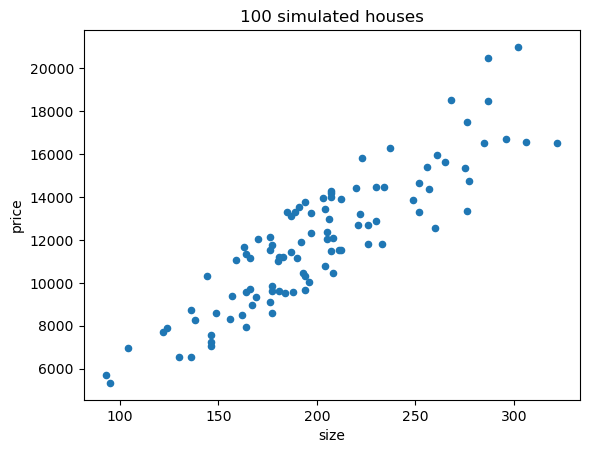

In [11]:
ax = houses[(houses['city']=="Mataram")].plot.scatter(x='size', y='price')
ax.set_title('100 simulated houses')

Text(0.5, 1.0, '100 simulated houses')

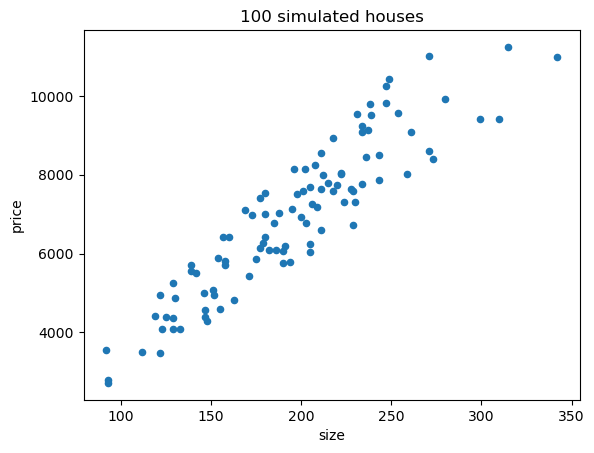

In [12]:
ax = houses[(houses['city']=="Mandalika")].plot.scatter(x='size', y='price')
ax.set_title('100 simulated houses')

Text(0.5, 1.0, '100 simulated houses')

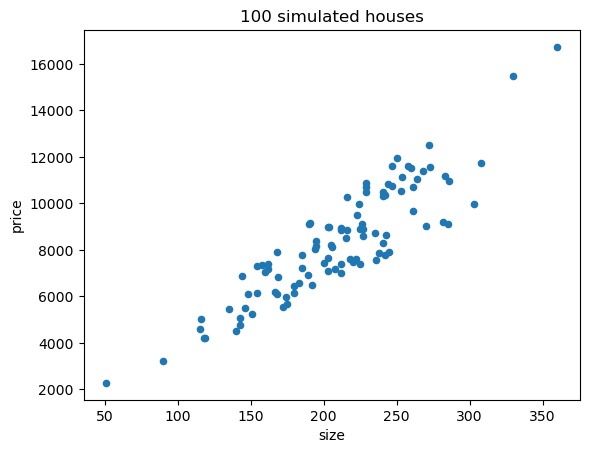

In [13]:
ax = houses[(houses['city']=="Senggigi")].plot.scatter(x='size', y='price')
ax.set_title('100 simulated houses')

Text(0.5, 1.0, '100 simulated houses')

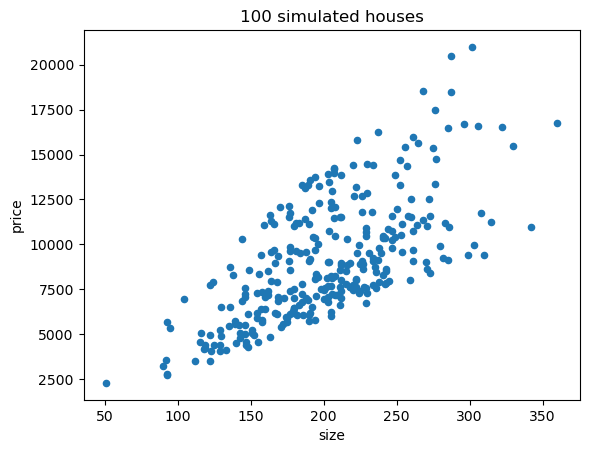

In [14]:
ax = houses.plot.scatter(x='size', y='price')
ax.set_title('100 simulated houses')

In [15]:
import seaborn as sns

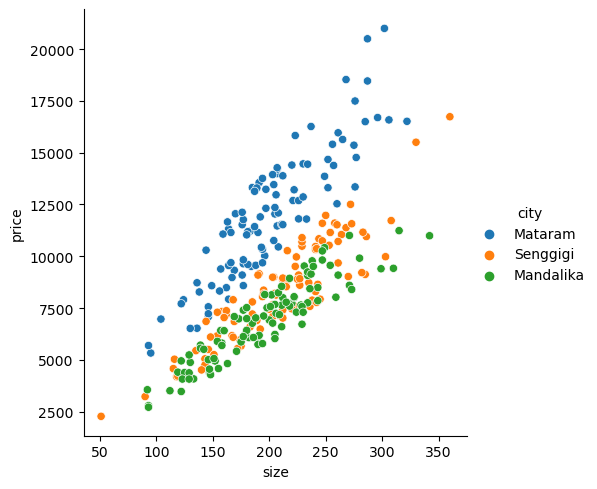

In [16]:
sns.relplot(data=houses, x="size", y="price",hue="city")

In [20]:
def a_dominates_b(a, b, to_min, to_max):

    n_better = 0

    for f in to_min:
        if a[f] > b[f]:
            return False
        n_better += a[f] < b[f]

    for f in to_max:
        if a[f] < b[f]:
            return False
        n_better += a[f] > b[f]

    if n_better > 0:
        return True
    return False

In [19]:
i = 1
i += 6 < 9
i

2

In [21]:
houses.to_dict(orient='index')

{0: {'city': 'Mataram', 'size': 185, 'price': 13318},
 1: {'city': 'Mataram', 'size': 208, 'price': 10455},
 2: {'city': 'Mataram', 'size': 302, 'price': 20994},
 3: {'city': 'Mataram', 'size': 249, 'price': 13859},
 4: {'city': 'Mataram', 'size': 207, 'price': 11466},
 5: {'city': 'Mataram', 'size': 285, 'price': 16497},
 6: {'city': 'Mataram', 'size': 169, 'price': 9326},
 7: {'city': 'Mataram', 'size': 252, 'price': 14673},
 8: {'city': 'Mataram', 'size': 207, 'price': 13989},
 9: {'city': 'Mataram', 'size': 221, 'price': 12692},
 10: {'city': 'Mataram', 'size': 164, 'price': 7933},
 11: {'city': 'Mataram', 'size': 183, 'price': 11211},
 12: {'city': 'Mataram', 'size': 256, 'price': 15405},
 13: {'city': 'Mataram', 'size': 176, 'price': 9098},
 14: {'city': 'Mataram', 'size': 157, 'price': 9390},
 15: {'city': 'Mataram', 'size': 184, 'price': 9517},
 16: {'city': 'Mataram', 'size': 220, 'price': 14402},
 17: {'city': 'Mataram', 'size': 192, 'price': 11902},
 18: {'city': 'Mataram', 

In [23]:
def find_skyline_brute_force(df, to_min, to_max):

    rows = df.to_dict(orient='index')

    skyline = set()

    for i in rows:

        dominated = False

        for j in rows:

            if i == j:
                continue

            if a_dominates_b(rows[j], rows[i], to_min, to_max):
                dominated = True
                break

        if not dominated:
            skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

In [24]:
skyline = find_skyline_brute_force(houses, to_min=['price'], to_max=['size'])

In [25]:
print(skyline)

0      False
1      False
2      False
3      False
4      False
       ...  
295    False
296    False
297     True
298    False
299     True
Length: 300, dtype: bool


In [27]:
type(skyline)

pandas.core.series.Series

Text(0.5, 1.0, 'Houses skyline')

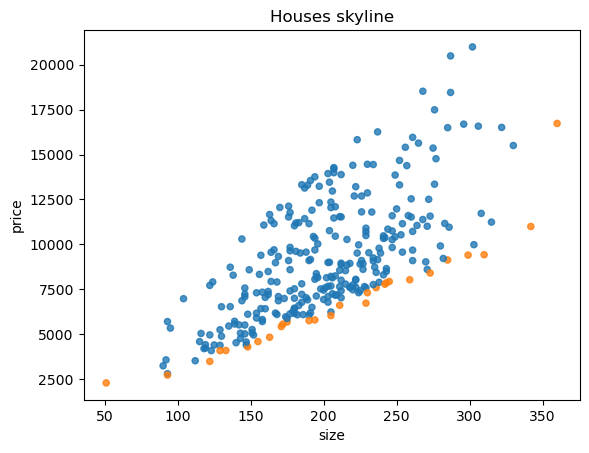

In [26]:
colors = skyline.map({True: 'C1', False: 'C0'})
ax = houses.plot.scatter(x='size', y='price', c=colors, alpha=0.8)
ax.set_title('Houses skyline')

pandas.core.series.Series

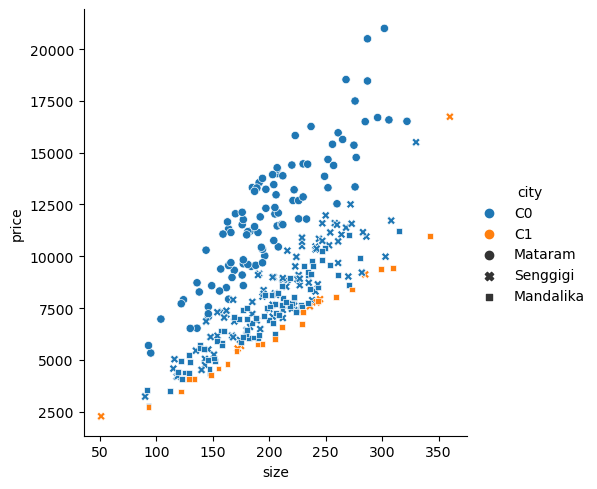

In [28]:
sns.relplot(data=houses, x="size", y="price",hue=colors,style="city")

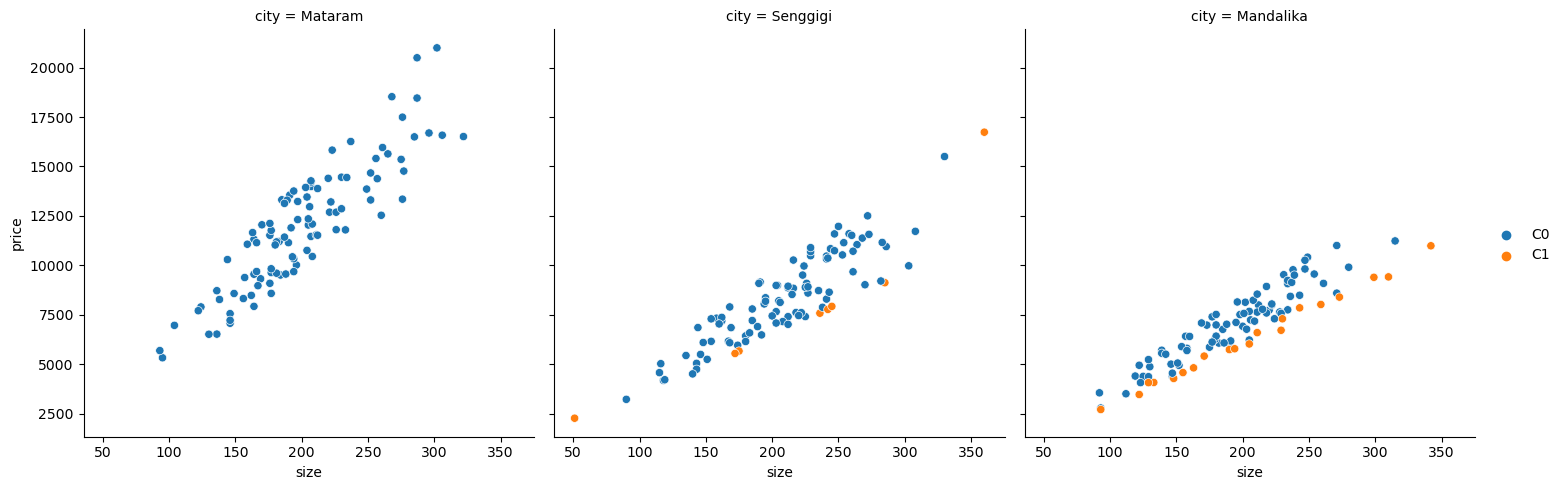

In [29]:
sns.relplot(data=houses, x="size", y="price",hue=colors,col="city")

In [ ]:
def count_diffs(a, b, to_min, to_max):
    n_better = 0
    n_worse = 0

    for f in to_min:
        n_better += a[f] < b[f]
        n_worse += a[f] > b[f]

    for f in to_max:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse


def find_skyline_bnl(df, to_min, to_max):
    """Finds the skyline using a block-nested loop."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_min, to_max)

            # Case 1
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 3
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        skyline = skyline.difference(to_drop)
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

In [41]:
skyline = find_skyline_bnl(houses, to_min=['price'], to_max=['size'])

colors = skyline.map({True: 'C1', False: 'C0'})

In [42]:
skyline

0      False
1      False
2      False
3      False
4      False
       ...  
295     True
296    False
297     True
298    False
299    False
Length: 300, dtype: bool

In [44]:
colors

0      C0
1      C0
2      C0
3      C0
4      C0
       ..
295    C1
296    C0
297    C1
298    C0
299    C0
Length: 300, dtype: object

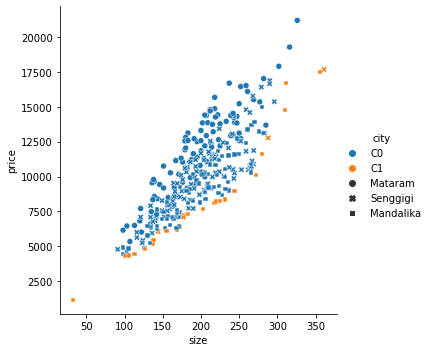

In [43]:
sns.relplot(data=houses, x="size", y="price",hue=colors,style="city")

In [46]:
for _ in range(30):
    houses = make_houses(n_houses=random.randint(120, 140), city_prices=city_prices)

    x = pd.testing.assert_series_equal(
        find_skyline_brute_force(df=houses, to_min=['price'], to_max=['size']),
        find_skyline_bnl(df=houses, to_min=['price'], to_max=['size'])
    )

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [56]:
from pandas import testing as tm
a = pd.Series([1, 2, 3, 4, 5])
b = pd.Series([1, 2, 3, 4, 6])
#print(tm.assert_series_equal(a, b))
print(a==b)

0     True
1     True
2     True
3     True
4    False
dtype: bool


In [57]:
import time

houses = make_houses(n_houses=5_000, city_prices=city_prices)

tic = time.time()
skyline = find_skyline_brute_force(df=houses, to_min=['price'], to_max=['size'])
print(f'Brute-force took {time.time() - tic:.3f} seconds')

tic = time.time()
skyline = find_skyline_bnl(df=houses, to_min=['price'], to_max=['size'])
print(f'Block nested loop took {time.time() - tic:.3f} seconds')

Brute-force took 17.917 seconds
Block nested loop took 0.281 seconds


Text(0.5, 1.0, 'Running time in seconds of the BNL algorithm')

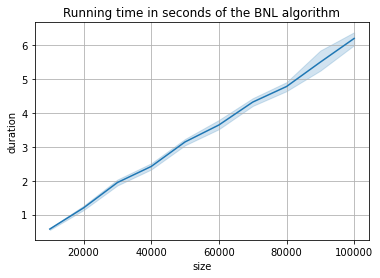

In [58]:
import seaborn as sns
import numpy as np

def measure_time(n):
    houses = make_houses(n_houses=n, city_prices=city_prices)
    tic = time.time()
    skyline = find_skyline_bnl(df=houses, to_min=['price'], to_max=['size'])
    return time.time() - tic

durations = pd.DataFrame([
    {'size': n, 'duration': measure_time(n)}
     for n in np.arange(10000, 110_000, 10000) for i in range(10)
])

ax = sns.lineplot(x='size', y='duration', data=durations)
ax.grid()
ax.set_title('Running time in seconds of the BNL algorithm')

Tugas : coba tambah kitanya lagi 2, jadi 5. jalankan sampai 
- sns.relplot(data=houses, x="size", y="price",hue=colors,col="city")
saja